In [0]:
import numpy as np
#import scipy as sc 
import pandas as pd
#import keras

In [0]:
import matplotlib.pyplot as plt

Preprocessing the order book and trade files:  

In [2]:
trades = pd.read_csv('/data/binance/trades/ETHBTC-modified_2.csv')
print(trades.shape)
trades.head()

(4710672, 6)


,TimeStamp,ExactTimeStamp,BuyType,Price,ID,Volume
0,1.521332e+09,1521332236315,False,0.069726,44207735,0.100
1,1.521332e+09,1521332236334,False,0.069726,44207736,0.030
2,1.521332e+09,1521332236375,True,0.069707,44207737,0.920
3,1.521332e+09,1521332236439,False,0.069726,44207738,0.050
4,1.521332e+09,1521332236986,True,0.069707,44207739,1.153


In [3]:
orders = pd.read_csv('/data/binance/orders/ETHBTC-modified.csv')
print(orders.shape)
orders.head()

(19010149, 4)


,TimeStamp,Buy/Sell,Price,Volume
0,1.521332e+09,B,0.069430,0.864
1,1.521332e+09,B,0.069429,0.327
2,1.521332e+09,B,0.069416,0.090
3,1.521332e+09,B,0.069406,0.084
4,1.521332e+09,B,0.069404,0.269


In [0]:
t_tstamps = trades.TimeStamp.values
t_unique = set(t_tstamps)
print("Total unique time steps in trades:", len(t_unique))

Total unique time steps in trades: 9515


In [0]:
o_tstamps = orders.TimeStamp.values
o_unique = set(o_tstamps)
print("Total unique time steps in orders:", len(o_unique))

Total unique time steps in orders: 9514


In [0]:
from datetime import datetime as dt

times = lambda x: dt.fromtimestamp(int(x)).strftime('%Y/%m/%d %H:%M:%S')

o_tstamps = orders.TimeStamp.apply(times)
t_tstamps = trades.TimeStamp.apply(times)

last_o = o_tstamps.index.get_values()[-1]
last_t = t_tstamps.index.get_values()[-1]
print("first order time: {}, last order time: {}".format(o_tstamps[0], o_tstamps[last_o]))
print("first trade time: {}, last trade time: {}".format(t_tstamps[0], t_tstamps[last_t]))

first order time: 2018/03/18 00:18:27, last order time: 2018/04/26 17:36:23
first trade time: 2018/03/18 00:18:27, last trade time: 2018/04/26 17:42:24


In [0]:
def preproc(data):
  data['AskPrice'] = data['Price']
  data['AskVol'] = data['Volume']
  data['type'] = np.where(np.array(data.BuyType), 'Ask', 'Bid') #'Ask' where BuyType is True and 'Buy' where its false 
  data.loc[data.type == 'Bid', 'AskPrice'] = np.nan
  data.loc[data.type == 'Bid', 'AskVol'] = np.nan
  data.rename(columns={'Price': 'BidPrice', 'Volume':'BidVol'}, inplace=True)
  data.loc[data.type == 'Ask', 'BidPrice'] = np.nan
  data.loc[data.type == 'Ask', 'BidVol'] = np.nan
  data.drop(['ID', 'BuyType', 'ExactTimeStamp'], axis=1, inplace=True)
  return data

trades = preproc(trades)
trades.head(8)

,TimeStamp,BidPrice,BidVol,AskPrice,AskVol,type
0,1.521332e+09,0.069726,0.100,NaN,NaN,Bid
1,1.521332e+09,0.069726,0.030,NaN,NaN,Bid
2,1.521332e+09,NaN,NaN,0.069707,0.920,Ask
3,1.521332e+09,0.069726,0.050,NaN,NaN,Bid
4,1.521332e+09,NaN,NaN,0.069707,1.153,Ask
5,1.521332e+09,NaN,NaN,0.069706,0.400,Ask
6,1.521332e+09,NaN,NaN,0.069706,0.043,Ask
7,1.521332e+09,0.069726,0.338,NaN,NaN,Bid


In [0]:
print("total bid orders: ", orders[orders['Buy/Sell'] == 'B']['Buy/Sell'].count())
print("total ask orders: ", orders[orders['Buy/Sell'] == 'S']['Buy/Sell'].count())
print("total bid trades: ", trades[trades['type'] == 'Bid']['type'].count())
print("total ask trades: ", trades[trades['type'] == 'Ask']['type'].count())

total bid orders:  9497147
total ask orders:  9513002
total bid trades:  2288624
total ask trades:  2422048


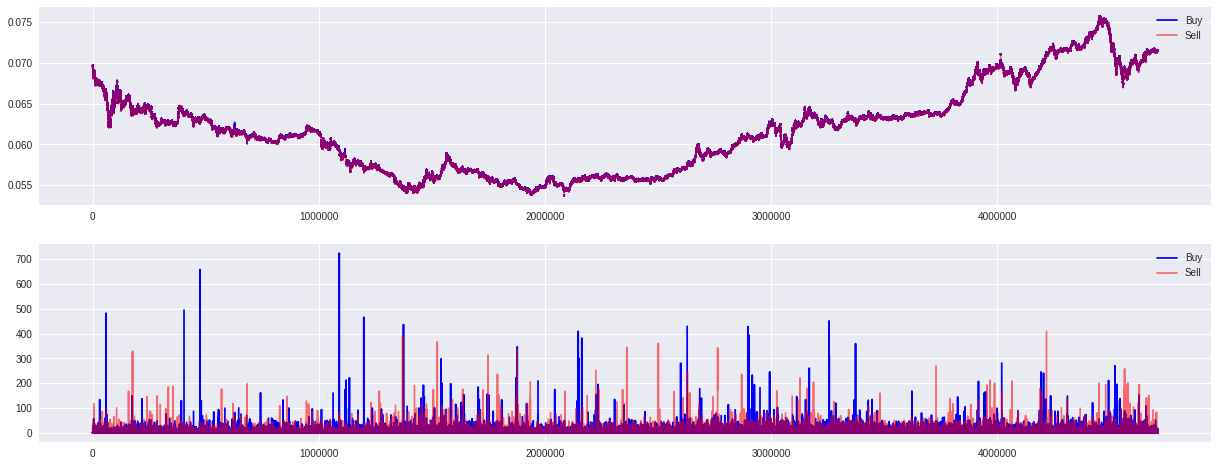

In [0]:
plt.figure(figsize=(21,8))
ax = plt.subplot(2,1,1)
plt.plot(trades['BidPrice'], color='b', label="Buy")
plt.plot(trades['AskPrice'], color='r', alpha=0.55, label="Sell")
plt.legend()
ax = plt.subplot(2,1,2)
plt.plot(trades['BidVol'], color='b', label="Buy")
plt.plot(trades['AskVol'], color='r', alpha=0.55, label="Sell")
plt.legend()

In [0]:
BidPrice = orders[orders['Buy/Sell'] == 'B']['Price']
AskPrice = orders[orders['Buy/Sell'] == 'S']['Price']
BidVol = orders[orders['Buy/Sell'] == 'B']['Volume']
AskVol = orders[orders['Buy/Sell'] == 'S']['Volume']

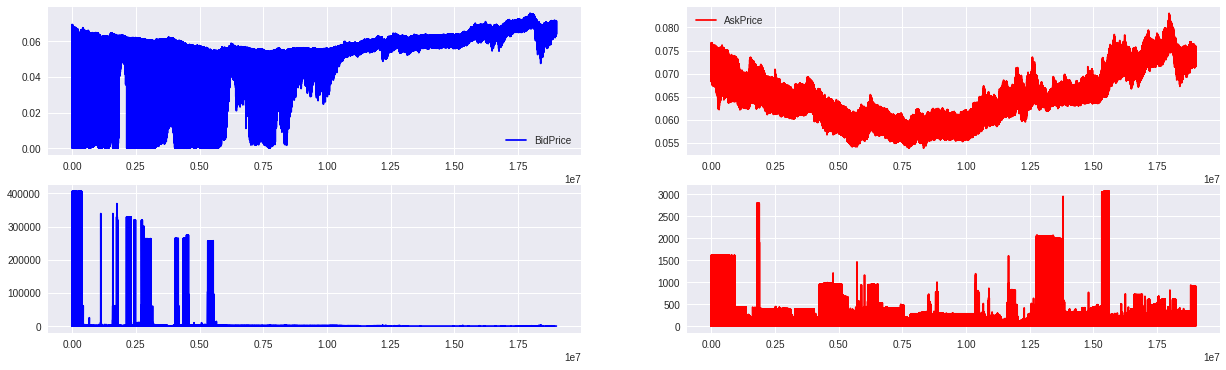

In [0]:
plt.figure(figsize=(21,6))
plt.subplot(2,2,1)
plt.plot(BidPrice, color='b', label='BidPrice')
plt.legend()
plt.subplot(2,2,2)
plt.plot(AskPrice, color='r', label='AskPrice')
plt.legend()
plt.subplot(2,2,3)
plt.plot(BidVol, color='b', label='BidVol')
plt.subplot(2,2,4)
plt.plot(AskVol, color='r', label='AskVol')
plt.show()
#Bid prices are really noisy entries from close to 0 all the way to asking price 

**Mid Trade Price per time step: **

(best traded ask (lowest) + best traded buy (highest))/2

source: https://arxiv.org/pdf/1709.01268.pdf

In [0]:
md_trades = trades.groupby('TimeStamp').agg({'BidPrice': max, 'AskPrice':min})

In [0]:
md_trades['MidPrice'] = 0
for row in md_trades.index:
  md_trades.loc[row, 'MidPrice'] = (md_trades.loc[row, 'BidPrice'] + md_trades.loc[row, 'AskPrice'])/2

In [0]:
md_trades.head()

,BidPrice,AskPrice,MidPrice
TimeStamp,,,
1.521332e+09,0.069726,0.069430,0.069578
1.521333e+09,0.069422,0.069105,0.069264
1.521333e+09,0.069048,0.068754,0.068901
1.521333e+09,0.068613,0.068362,0.068488
1.521334e+09,0.068379,0.068140,0.068260


In [0]:
bid_order = orders[orders['Buy/Sell']=='B'][['TimeStamp','Price']]
ask_order = orders[orders['Buy/Sell']=='S'][['TimeStamp','Price']]

#mean ask order and mean bid order per timestamp
mn_bid_orders = bid_order.groupby('TimeStamp').agg({'Price':pd.Series.mean})
mn_ask_orders = ask_order.groupby('TimeStamp').agg({'Price':pd.Series.mean})

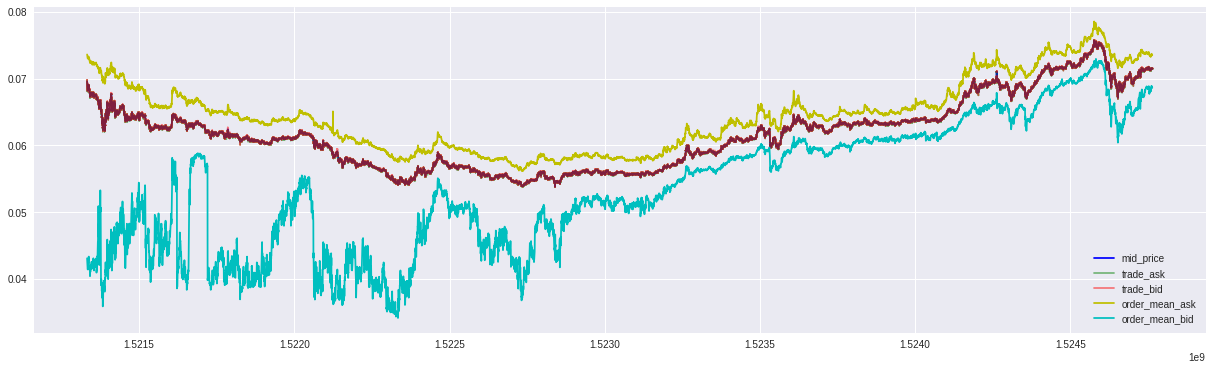

In [0]:
plt.figure(figsize=(21,6))
plt.plot(md_trades.MidPrice, color='b', label='mid_price')
plt.plot(trades.set_index('TimeStamp').AskPrice, color='g', alpha=0.5, label='trade_ask')
plt.plot(trades.set_index('TimeStamp').BidPrice, color='r', alpha=0.5, label='trade_bid')
plt.plot(mn_ask_orders.Price, color='y', label='order_mean_ask')
plt.plot(mn_bid_orders.Price, color='c', label='order_mean_bid')
plt.legend()

From above, the MidTraded, trade_ask and trade_bid are very much aligned, the order_mean_ask is higher which is usual but follows similar pattern as the other three. The order_mean_bid prices though are really friggin noisy 

Creating a dataframe with mid trade prices, then merge with order book data to be used for training: 

In [0]:
y = pd.DataFrame(md_trades.MidPrice)
y.reset_index(inplace=True)

In [0]:
train_df = orders.merge(y, on='TimeStamp', how='outer')

In [0]:
#Saving the merged dataframe into a new csv file for DL
train_df.to_csv('/content/drive/My Drive/Vega/MachineLearning/data/binance/train_df.csv', index=False)

**Next Price - ** Creating another training data with Ys shifted by one time stemp to model the next traded value:

In [0]:
y_2 = pd.DataFrame(md_trades.MidPrice.shift(-1))
y_2.reset_index(inplace=True)

In [0]:
train_df_2 = orders.merge(y_2, on='TimeStamp', how='inner') #inner join here to get rid of the extra trade time stamp which is also nan now after shifting 

In [0]:
#Saving the merged dataframe into a new csv file for DL
train_df_2.to_csv('/content/drive/My Drive/Vega/MachineLearning/data/binance/train_df_nextPrice.csv', index=False)